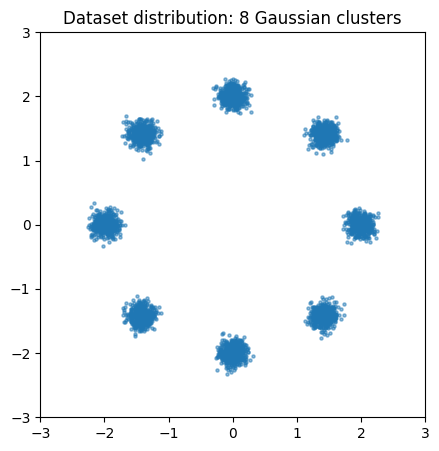

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from ipywidgets import interact, IntSlider
import math

# =============== 数据分布：8个高斯点 ===============
# =============== 数据分布：4个高斯点 ===============
def sample_target(n=1024):
    centers = [
        (math.sqrt(2),-math.sqrt(2)),   # 右上
        (2,0),   # 右
        (math.sqrt(2),math.sqrt(2)),   # 右上
        (-2,0),  # 左
        (-math.sqrt(2),math.sqrt(2)),   # 右上
        (0,2),   # 上
        (-math.sqrt(2),-math.sqrt(2)),   # 右上
        (0,-2)   # 下
    ]
    data = []
    for cx, cy in centers:
        pts = np.random.randn(n // len(centers), 2) * 0.1 + np.array([cx, cy])
        data.append(pts)
    return np.concatenate(data, axis=0)

def visualize_dataset_distribution(n=40960):
    data = sample_target(n)
    plt.figure(figsize=(5,5))
    plt.scatter(data[:,0], data[:,1], s=5, alpha=0.5, c='tab:blue')
    plt.title("Dataset distribution: 8 Gaussian clusters")
    plt.xlim(-3,3)
    plt.ylim(-3,3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

    
# =============== Flow Matching Model ===============

# ---- sinusoidal 时间 embedding (类似 diffusion) ----
class TimeEmbedding(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
    def forward(self, t):
        # t: (B,1)
        half = self.dim // 2
        freqs = torch.exp(
            -math.log(10000) * torch.arange(0, half, dtype=torch.float32, device=t.device) / half
        )
        angles = t * freqs[None, :]
        emb = torch.cat([torch.sin(angles), torch.cos(angles)], dim=-1)
        return emb  # (B, dim)

# ---- 增强版 FlowNet ----
class FlowNet(nn.Module):
    def __init__(self, x_dim=2, hidden=256, time_dim=64, depth=4):
        super().__init__()
        self.time_mlp = TimeEmbedding(time_dim)
        layers = []
        in_dim = x_dim + time_dim
        for i in range(depth):
            layers.append(nn.Linear(in_dim if i==0 else hidden, hidden))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden, x_dim))
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        # t shape: (B,1)
        t_emb = self.time_mlp(t)  # (B, time_dim)
        inp = torch.cat([x, t_emb], dim=-1)
        return self.net(inp)
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FlowNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# =============== Flow Matching 训练目标 ===============
def train_flow(model, steps=2000, batch_size=256, save_path="flow_model.pth"):
    for step in range(steps):
        x1 = torch.tensor(sample_target(batch_size),dtype=torch.float32,device=device)
        x0 = torch.randn_like(x1)
        t = torch.rand(batch_size,1,device=device)
        xt = (1-t)*x0 + t*x1
        v_true = x1 - x0
        v_pred = model(xt,t)
        loss = ((v_pred - v_true)**2).mean()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step % 500 == 0:
            print(f"Step {step} loss {loss.item():.4f}")
    # ---- 保存模型 ----
    torch.save(model.state_dict(), save_path)
    print(f"模型已保存到 {save_path}")

# =============== Inference 可视化 ===============
@torch.no_grad()
def sample_flow(model, n=1000, T=50, K=8):
    x = torch.randn(n,2,device=device)
    traj = [x.cpu().numpy()]
    theta = torch.atan2(x[:, 1], x[:, 0])          # [-π, π]
    
    width  = 2 * math.pi / K                               # wedge width
    offset = math.pi / 2 - width / 2                       # start of sector 0
    theta_shifted = torch.remainder(theta - offset, 2 * math.pi)
    sectors = torch.floor(theta_shifted / width).long()    # 0..K-1
    
    for i in range(1,T+1):
        t = torch.full((n,1), i/T, device=device)
        v = model(x,t)/T
        x = x + v
        traj.append(x.cpu().numpy())
    return traj, sectors

def visualize_traj(traj, sectors):
    """
    traj: list of [B, D] arrays (numpy or torch.cpu numpy), trajectory over time
    sectors: [B] integer IDs (numpy array or torch tensor)
    """
    # normalize sectors to numpy int array
    if hasattr(sectors, "detach"):  # torch tensor
        sectors_np = sectors.detach().cpu().numpy()
    else:
        sectors_np = np.asarray(sectors)
    sectors_np = sectors_np.astype(np.int64).reshape(-1)

    K = int(sectors_np.max()) + 1
    palette = [plt.get_cmap("tab10")(i % 10) for i in range(K)]

    def plot_step(k=0):
        pts = traj[k]
        # ensure pts is numpy
        if hasattr(pts, "detach"):  # torch tensor
            pts = pts.detach().cpu().numpy()
        else:
            pts = np.asarray(pts)

        plt.figure(figsize=(5,5))
        for s in range(K):
            mask = (sectors_np == s)
            if np.any(mask):
                plt.scatter(
                    pts[mask, 0], pts[mask, 1],
                    s=6, alpha=0.75, color=palette[s], label=f"sector {s}"
                )
        plt.xlim(-3, 3)
        plt.ylim(-3, 3)
        plt.gca().set_aspect("equal", adjustable="box")
        plt.title(f"Flow Matching step {k}/{len(traj)-1}")
        plt.legend(markerscale=2, fontsize=8, loc="upper right", frameon=False, ncol=min(K, 2))
        plt.show()

    interact(plot_step, k=IntSlider(min=0, max=len(traj)-1, step=1, value=0))

visualize_dataset_distribution(n=4096)

In [13]:
# 第一次训练并保存模型
train_flow(model, steps=30000, save_path="flow_model_3W.pth",batch_size=256)

Step 0 loss 1.8856
Step 500 loss 1.6097
Step 1000 loss 2.0703
Step 1500 loss 1.8808
Step 2000 loss 1.7649
Step 2500 loss 1.8433
Step 3000 loss 1.8528
Step 3500 loss 1.8632
Step 4000 loss 1.9111
Step 4500 loss 1.7268
Step 5000 loss 1.9029
Step 5500 loss 1.8367
Step 6000 loss 1.7386
Step 6500 loss 1.5596
Step 7000 loss 1.7330
Step 7500 loss 1.9852
Step 8000 loss 1.8482
Step 8500 loss 1.8564
Step 9000 loss 1.9594
Step 9500 loss 1.7337
Step 10000 loss 1.6620
Step 10500 loss 1.8163
Step 11000 loss 2.0745
Step 11500 loss 2.1833
Step 12000 loss 1.8765
Step 12500 loss 1.6284
Step 13000 loss 1.7944
Step 13500 loss 1.7788
Step 14000 loss 1.9629
Step 14500 loss 1.6907
Step 15000 loss 1.5822
Step 15500 loss 1.8575
Step 16000 loss 1.8062
Step 16500 loss 1.8018
Step 17000 loss 1.9098
Step 17500 loss 1.9765
Step 18000 loss 1.7775
Step 18500 loss 1.7145
Step 19000 loss 1.9166
Step 19500 loss 2.0076
Step 20000 loss 1.7682
Step 20500 loss 1.7875
Step 21000 loss 1.8887
Step 21500 loss 1.7868
Step 22000 l

In [14]:
# ---- 加载模型 ----
loaded_model = FlowNet().to(device)
loaded_model.load_state_dict(torch.load("flow_model_3W.pth", map_location=device))
loaded_model.eval()
print("模型已加载，可以用于推理。")

# ---- 用加载后的模型采样 ----
trajectories, sectors = sample_flow(loaded_model, n=80000, T=50)
visualize_traj(trajectories, sectors)

模型已加载，可以用于推理。


interactive(children=(IntSlider(value=0, description='k', max=50), Output()), _dom_classes=('widget-interact',…

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider

# ---- 簇中心 ----
centers = torch.tensor([
	[ 2, 0],   # 右
	[-2, 0],  # 左
	[ 0, 2],  # 上
	[ 0,-2],   # 下
 	[math.sqrt(2),-math.sqrt(2)],
    [-math.sqrt(2),-math.sqrt(2)],
    [-math.sqrt(2),math.sqrt(2)],
    [math.sqrt(2),math.sqrt(2)],
], dtype=torch.float32)

# ---- Reward function (clean space 定义) ----
# def reward_function_torch(xy, sigma=0.4, radius=1.0):
# 	device = xy.device
# 	centers_device = centers.to(device)
# 	diff = xy[:, None, :] - centers_device[None, :, :]   # (N,4,2)
# 	dist = diff.norm(dim=-1)                             # (N,4)
# 	r = torch.exp(-0.5*(dist/sigma)**2)
# 	r = torch.where(dist <= radius, r, torch.zeros_like(r))  # 半径外置 0
 
# 	# assign different weights for different cluster
#  	# theta = torch.atan2(xy[:, 1], xy[:, 0])
# 	# width  = 2 * math.pi / K                               # wedge width
#     # offset = math.pi / 2 - width / 2                       # start of sector 0
#     # theta_shifted = torch.remainder(theta - offset, 2 * math.pi)
#     # sectors = torch.floor(theta_shifted / width).long()    # 0..K-1
    
#     # r *= sectors
# 	return r.max(dim=1).values

def reward_function_torch(xy, sigma=0.4, radius=1.0, alpha=0.1):
    """
    Gaussian bump around each center (within radius),
    reweighted by an angular prior that *decays clockwise* from +Y.

    Weight per center c:
        w(c) = exp( -alpha * theta_cw(c) ),  theta_cw in [0, 2π)
    where theta_cw is the clockwise angle of the center from +Y.
    The top center (pointing to +Y) gets the largest weight (1.0).
    """
    device = xy.device
    C = centers.shape[0]
    centers_device = centers.to(device)                  # (C, 2)

    # ---- base Gaussian per sample-center ----
    diff = xy[:, None, :] - centers_device[None, :, :]   # (N, C, 2)
    dist = diff.norm(dim=-1)                             # (N, C)
    r = torch.exp(-0.5 * (dist / sigma) ** 2)            # (N, C)
    r = torch.where(dist <= radius, r, torch.zeros_like(r))

    # ---- angular weight per center (decay clockwise from +Y) ----
    # angle of center in [0, 2π)
    theta = torch.atan2(centers_device[:, 1], centers_device[:, 0])  # (C,)
    theta = torch.remainder(theta, 2 * math.pi)

    # clockwise angle from +Y:
    # +Y corresponds to angle π/2 in atan2; clockwise means subtract and wrap
    theta_cw = torch.remainder((math.pi / 2) - theta, 2 * math.pi)    # (C,)

    # exponential decay
    w = torch.exp(-alpha * theta_cw)                                  # (C,)
    # (optional) normalize so the largest weight is exactly 1
    w = w / w.max()
    # w = 1.0 - (theta_cw / (2 * math.pi))
	# w = torch.clamp(w, 0.0, 1.0)
 	# w = w / w.max()
	

    # apply weights and aggregate
    r_weighted = r * w[None, :]                                       # (N, C)
    return r_weighted.max(dim=1).values                               # (N,)



# ---- 可视化 clean + noise reward ----
@torch.no_grad()
def visualize_both_rewards(model, sigma=0.4, radius=1.0, T=50,
						   grid_size=200, lim=3, alpha=0.75):
	device = next(model.parameters()).device

	# ====== 1. 真实 reward (clean space) ======
	xs = np.linspace(-lim, lim, grid_size)
	ys = np.linspace(-lim, lim, grid_size)
	grid = np.stack(np.meshgrid(xs, ys), axis=-1).reshape(-1,2)
	xy_clean = torch.tensor(grid, dtype=torch.float32, device=device)
	rewards_clean = reward_function_torch(xy_clean, sigma=sigma, radius=radius, alpha=alpha)
	R_clean = rewards_clean.cpu().numpy().reshape(grid_size, grid_size)

	# ====== 2. noise -> clean -> reward ======
	x = torch.tensor(grid, dtype=torch.float32, device=device)
	for i in range(1, T+1):
		t = torch.full((x.shape[0],1), i/T, device=device)
		v = model(x, t)/T
		x = x + v
	xy_mapped = x
	rewards_noise = reward_function_torch(xy_mapped, sigma=sigma, radius=radius, alpha=alpha)
	R_noise = rewards_noise.cpu().numpy().reshape(grid_size, grid_size)

	# ====== Plot side-by-side ======
	fig, axs = plt.subplots(1, 2, figsize=(12,6))
	
	import matplotlib.patches as patches

	for (cx, cy) in centers:
		circ = patches.Circle((cx, cy), radius, fill=False,
							edgecolor="white", linestyle="--", linewidth=1.5)
		axs[0].add_patch(circ)

	im0 = axs[0].imshow(R_clean, extent=[-lim,lim,-lim,lim],
						origin="lower", cmap="viridis",vmin=0, vmax=1)
	axs[0].set_title("True Reward (clean space)")
	axs[0].scatter(centers[:,0], centers[:,1], c="red", marker="x", s=80)
	plt.colorbar(im0, ax=axs[0], fraction=0.046, pad=0.04)

	im1 = axs[1].imshow(R_noise, extent=[-lim,lim,-lim,lim],
						origin="lower", cmap="viridis",vmin=0, vmax=1)
	axs[1].set_title("Reward in Noise Space (via flow)")
	plt.colorbar(im1, ax=axs[1], fraction=0.046, pad=0.04)

	plt.suptitle(f"σ={sigma}, radius={radius}, T={T}, grid={grid_size}, lim={lim}")
	plt.show()


# ---- 交互控件 ----
def interactive_plot(sigma, radius, T, grid_size, lim, alpha):
	visualize_both_rewards(model, sigma=sigma, radius=radius, T=T,
						   grid_size=grid_size, lim=lim, alpha=alpha)

interact(
	interactive_plot,
	sigma=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.4, description="σ"),
	radius=FloatSlider(min=0.5, max=3.0, step=0.1, value=1.0, description="radius"),
	T=IntSlider(min=10, max=100, step=5, value=50, description="T (steps)"),
	grid_size=IntSlider(min=50, max=400, step=10, value=200, description="grid_size"),
	lim=FloatSlider(min=2.0, max=15.0, step=0.5, value=3.0, description="lim"),
 	alpha=FloatSlider(min=0, max=1.0, step=0.1, value=0.75, description="alpha")
)


interactive(children=(FloatSlider(value=0.4, description='σ', max=1.0, min=0.1, step=0.05), FloatSlider(value=…

<function __main__.interactive_plot(sigma, radius, T, grid_size, lim, alpha)>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown

# ---- 簇中心 ----
centers = torch.tensor([
    [ 2, 0],   # 右
    [-2, 0],  # 左
    [ 0, 2],  # 上
    [ 0,-2]   # 下
], dtype=torch.float32)

# ---- Reward function ----
def reward_function_torch(xy, sigma=0.4, radius=1.0, mode="equal", custom_scales=None):
    device = xy.device
    centers_device = centers.to(device)

    # 选择不同 reward 模式
    if mode == "equal":
        reward_scales = torch.tensor([1.0, 1.0, 1.0, 1.0], dtype=torch.float32)
    elif mode == "clockwise":
        # 顺时针 (右, 下, 左, 上)
        reward_scales = torch.tensor([1.0, 2.0, 4.0, 8.0], dtype=torch.float32)
        # 注意：centers 顺序是 [右, 左, 上, 下]，所以要对应重排
        reward_scales = reward_scales[torch.tensor([0,2,3,1])]
    elif mode == "custom" and custom_scales is not None:
        reward_scales = torch.tensor(custom_scales, dtype=torch.float32)
    else:
        raise ValueError("Invalid mode or missing custom_scales")

    reward_scales = reward_scales.to(device)

    diff = xy[:, None, :] - centers_device[None, :, :]   # (N,4,2)
    dist = diff.norm(dim=-1)                             # (N,4)

    r = torch.exp(-0.5*(dist/sigma)**2)
    r = torch.where(dist <= radius, r, torch.zeros_like(r))
    r = r * reward_scales[None, :]                       # 每个簇乘不同最大值

    return r.max(dim=1).values, reward_scales


# ---- 可视化 clean + noise reward ----
# ---- 可视化 clean + noise reward (Gaussian sampling) ----
@torch.no_grad()
def visualize_both_rewards_gaussian(model, sigma=0.4, radius=1.0, T=50,
                                    N=20000, std=1.0, lim=3, mode="equal"):
    """
    N   : 采样点数量
    std : 高斯采样标准差
    """
    device = next(model.parameters()).device

    # ====== 1. 从高斯分布采样 noise ======
    noise = torch.randn(N, 2, device=device) * std  # N 个点
    xy_clean = noise.clone()

    # Clean reward
    rewards_clean, reward_scales = reward_function_torch(xy_clean, sigma=sigma, radius=radius, mode=mode)
    vmax_val = reward_scales.max().item()

    # ====== 2. noise -> clean -> reward ======
    x = noise.clone()
    for i in range(1, T+1):
        t = torch.full((x.shape[0],1), i/T, device=device)
        v = model(x, t)/T
        x = x + v
    xy_mapped = x
    rewards_noise, _ = reward_function_torch(xy_mapped, sigma=sigma, radius=radius, mode=mode)

    # ====== Plot scatter ======
    fig, axs = plt.subplots(1, 2, figsize=(12,6))

    # Clean space
    sc0 = axs[0].scatter(xy_clean[:,0].cpu(), xy_clean[:,1].cpu(),
                         c=rewards_clean.cpu(), cmap="viridis", s=5, vmin=0, vmax=vmax_val)
    axs[0].set_xlim([-lim, lim]); axs[0].set_ylim([-lim, lim])
    axs[0].set_title("True Reward (clean space, Gaussian samples)")
    plt.colorbar(sc0, ax=axs[0], fraction=0.046, pad=0.04)

    # Noise space
    sc1 = axs[1].scatter(noise[:,0].cpu(), noise[:,1].cpu(),
                         c=rewards_noise.cpu(), cmap="viridis", s=5, vmin=0, vmax=vmax_val)
    axs[1].set_xlim([-lim, lim]); axs[1].set_ylim([-lim, lim])
    axs[1].set_title("Reward in Noise Space (via flow, Gaussian samples)")
    plt.colorbar(sc1, ax=axs[1], fraction=0.046, pad=0.04)

    plt.suptitle(f"mode={mode}, σ={sigma}, radius={radius}, T={T}, N={N}, std={std}")
    plt.show()


# ---- 交互控件 (Gaussian 版本) ----
def interactive_plot_gaussian(sigma, radius, T, N, std, lim, mode):
    visualize_both_rewards_gaussian(model, sigma=sigma, radius=radius, T=T,
                                    N=N, std=std, lim=lim, mode=mode)

interact(
    interactive_plot_gaussian,
    sigma=FloatSlider(min=0.1, max=1.0, step=0.05, value=0.4, description="σ"),
    radius=FloatSlider(min=0.5, max=3.0, step=0.1, value=1.0, description="radius"),
    T=IntSlider(min=10, max=100, step=5, value=50, description="T (steps)"),
    N=IntSlider(min=1000, max=50000, step=1000, value=20000, description="N samples"),
    std=FloatSlider(min=0.5, max=5.0, step=0.5, value=1.0, description="noise std"),
    lim=FloatSlider(min=2.0, max=15.0, step=0.5, value=3.0, description="lim"),
    mode=Dropdown(options=["equal","clockwise","custom"], value="equal", description="reward_mode")
)


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Backbone-induced manifold
x = np.linspace(-3, 3, 400)
y = np.sin(x) * 0.8
manifold = np.vstack([x, y]).T

# RL noise policy 选的点 (manifold 上)
a0 = np.array([1.0, np.sin(1.0) * 0.8])

# True optimal action (在 manifold 外)
astar = np.array([1.0, 1.6])

# Residual 修正
residual_corrected = a0 + 0.6 * (astar - a0)

fig, axes = plt.subplots(1, 2, figsize=(12,6), sharex=True, sharey=True)

# ---------------- 左图: 只有 noise policy ----------------
ax = axes[0]
ax.plot(manifold[:,0], manifold[:,1], color="blue", lw=2, label=r"Manifold $\mathcal{M}_\theta(s)$")
ax.scatter(a0[0], a0[1], color="gold", s=120, edgecolors="k", zorder=3, label=r"In-domain optimal $a_0$")
ax.scatter(astar[0], astar[1], color="red", marker="*", s=200, zorder=4, label=r"True optimal $a^\star$")
ax.set_title("Noise policy only: in-domain optima")
ax.grid(True)
ax.axis("equal")
ax.legend()

# ---------------- 右图: Noise + Residual ----------------
ax = axes[1]
ax.plot(manifold[:,0], manifold[:,1], color="blue", lw=2, label=r"Manifold $\mathcal{M}_\theta(s)$")
ax.scatter(a0[0], a0[1], color="gold", s=120, edgecolors="k", zorder=3, label=r"Noise action $a_0$")
ax.scatter(astar[0], astar[1], color="red", marker="*", s=200, zorder=4, label=r"True optimal $a^\star$")
ax.scatter(residual_corrected[0], residual_corrected[1], color="green", s=120, edgecolors="k", zorder=3, label="Residual-corrected")
# residual arrow
ax.arrow(a0[0], a0[1], residual_corrected[0]-a0[0], residual_corrected[1]-a0[1],
         head_width=0.08, color="green", alpha=0.8, length_includes_head=True)
ax.plot([a0[0], astar[0]], [a0[1], astar[1]], 'k--', lw=1, alpha=0.6)
ax.set_title("Noise + Residual: extrapolate beyond manifold")
ax.grid(True)
ax.axis("equal")
ax.legend()

plt.suptitle("Noise → in-domain optima vs. Residual → extrapolation to better actions", fontsize=14)
plt.show()
